In [480]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as metrics
import sklearn.tree as tree
import graphviz
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn import neighbors
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import (cross_val_score, GridSearchCV, 
                                     train_test_split, StratifiedShuffleSplit)
from sklearn.model_selection import learning_curve
import time

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import warnings
warnings.filterwarnings("ignore")

## Added for A3
from sklearn.cluster import MiniBatchKMeans
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA, FastICA, LatentDirichletAllocation
from sklearn.random_projection import SparseRandomProjection

# Prep the data

In [150]:
# Adult dataset

#The adults dataset was downloaded from https://www.kaggle.com/uciml/adult-census-income
#adults = pd.read_csv('adult/adult.csv')

#df = pd.read_csv('datasets/adult/adult.data.txt', header=None)
adults = pd.read_csv('https://raw.githubusercontent.com/sventopia/ML/master/datasets/adult/adult.data.txt', header=None)
adults.columns = ['age','workclass','fnlwgt','education','education-num','marital-status',
                  'occupation','relationship','race','sex','capital-gain','capital-loss',
                  'hours-per-week','native-country','income']
adults.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [151]:
adults = adults.drop(['capital-gain','capital-loss'], axis=1)
#split off the response variable
y = adults['income'].to_frame()
X = adults.loc[:, adults.columns != 'income']

#encode the target variable
le = LabelEncoder()
y_enc = le.fit_transform(y.values.ravel())

#encode dummy variables
X_enc = pd.get_dummies(X)

scaler = StandardScaler()
X_std = scaler.fit_transform(X_enc)

adults_y = y_enc
adults_X = X_std

In [152]:
# breast cancer dataset

#The breast cancer dataset was downloaded from https://www.kaggle.com/uciml/breast-cancer-wisconsin-data

cancer = pd.read_csv('https://raw.githubusercontent.com/sventopia/gt_ml_pub/master/datasets/bcdata.csv')
cancer.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [153]:
cancer.dropna(axis=1, inplace=True)
X = cancer.copy()
cancer_X = X.drop(['id','diagnosis'],1)

In [156]:
cancer_y = np.array(cancer['diagnosis'])

for i in range(0, len(cancer_y)):
    if cancer_y[i] == "B":
        cancer_y[i] = 0
    if cancer_y[i] == "M":
        cancer_y[i] = 1

In [340]:
def evalKmeans(X, y, max_clusters):
    results = {}
    results['SSE'] = []
    results['ARI'] = [] #adjusted Rand index
    results['AMI'] = []
    results['homogeneity'] = []
    results['completeness'] = []
    results['v-measure'] = []
    results['FMI'] = []
    results['DBI'] = []
    results['CHI'] = []
    for i in range(2,max_clusters):
        km = MiniBatchKMeans(n_clusters = i, max_iter = 300).fit(X)
        labels = km.predict(X)
        results['SSE'].append(km.inertia_)
        results['ARI'].append(metrics.adjusted_rand_score(y, labels))
        results['AMI'].append(metrics.adjusted_mutual_info_score(y, labels))
        results['homogeneity'].append(metrics.homogeneity_score(y, labels))
        results['completeness'].append(metrics.completeness_score(y, labels))
        results['v-measure'].append(metrics.v_measure_score(y, labels))
        results['FMI'].append(metrics.fowlkes_mallows_score(y, labels))
        results['DBI'].append(metrics.davies_bouldin_score(X, labels))
        results['CHI'].append(metrics.calinski_harabasz_score(X, labels))
        
    #Find the ideal cluster size based on maximizing homogeneity and the ARI
    a, h = np.array(results['ARI']), np.array(results['homogeneity'])
    difference, average = np.absolute(a-h), np.mean([a, h], axis=0)

    m = 0
    for i in np.argsort(difference):
        if average[i] > m:
            m = average[i]
            idx = i

    return results, idx+2

In [543]:
max_clusters = 21
r, cluster_size = evalKmeans(cancer_X, cancer_y, max_clusters)
cancer_cluster_size_km = cluster_size

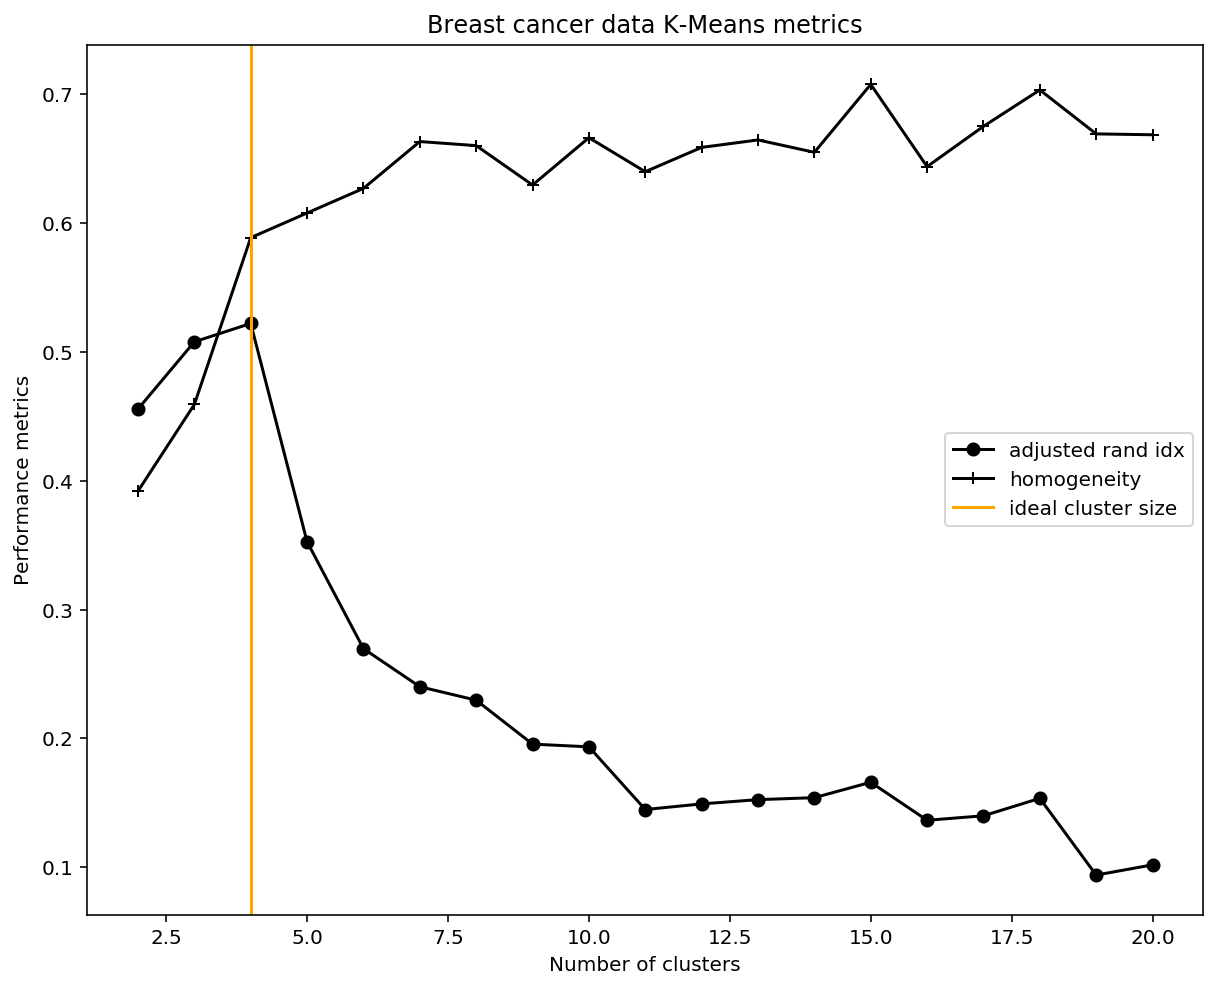

In [544]:
# plot
plt.figure(figsize=(round((max_clusters-1)/2),8))
plt.plot(range(2, max_clusters), r['ARI'], marker='o', c='black', label='adjusted rand idx')
plt.plot(range(2, max_clusters), r['homogeneity'], marker='+', c='black', label='homogeneity')
#plt.plot(range(2, max_clusters), r['DBI'], marker='v', c='black', label='DBI')
#plt.plot(range(2, max_clusters), r['completeness'], marker='v', c='black', label='completeness')
#plt.plot(range(2, max_clusters), r['v-measure'], marker='^', c='black', label='v-measure')
#plt.plot(range(2, max_clusters), r['FMI'], marker='D', c='black', label='Fowlkes-Mallows idx')
#plt.plot(range(2, max_clusters), r['DBI'], marker='x', c='black', label='Davies-Bouldin idx')
plt.axvline(cluster_size, 0, 1, label='ideal cluster size', c="orange")
plt.legend(loc="best")
plt.xlabel('Number of clusters')
plt.ylabel('Performance metrics')
plt.title('Breast cancer data K-Means metrics')
plt.show()

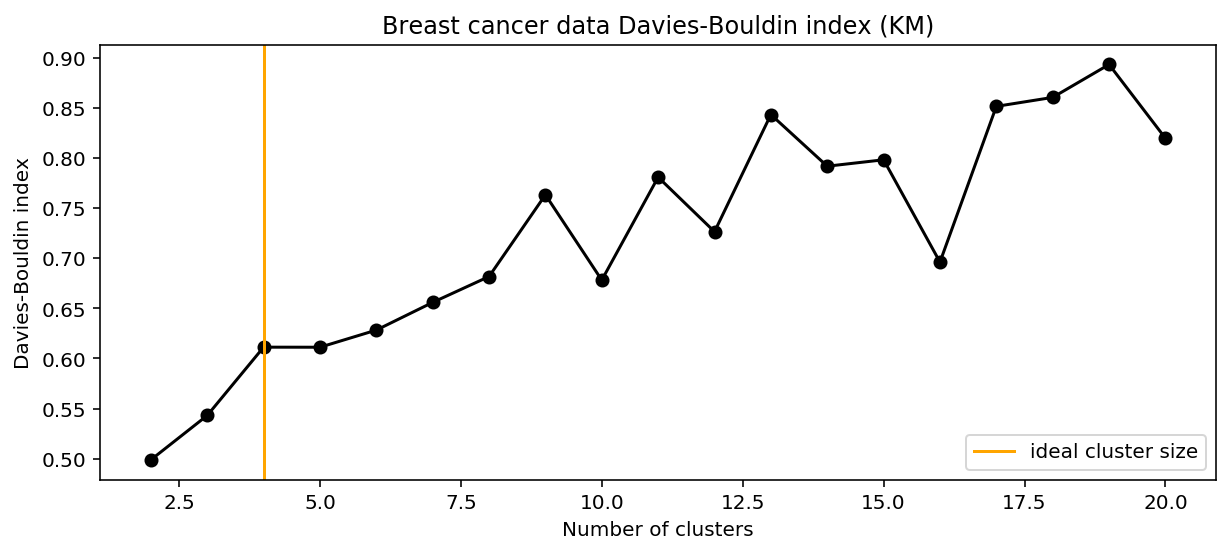

In [548]:
# plot DBI
plt.figure(figsize=(round((max_clusters-1)/2),4))
plt.plot(range(2, max_clusters), r['DBI'], marker='o', c='black')
plt.axvline(cluster_size, 0, 1, label='ideal cluster size', c="orange")
plt.legend(loc="best")
plt.xlabel('Number of clusters')
plt.ylabel('Davies-Bouldin index')
plt.title('Breast cancer data Davies-Bouldin index (KM)')
plt.show()

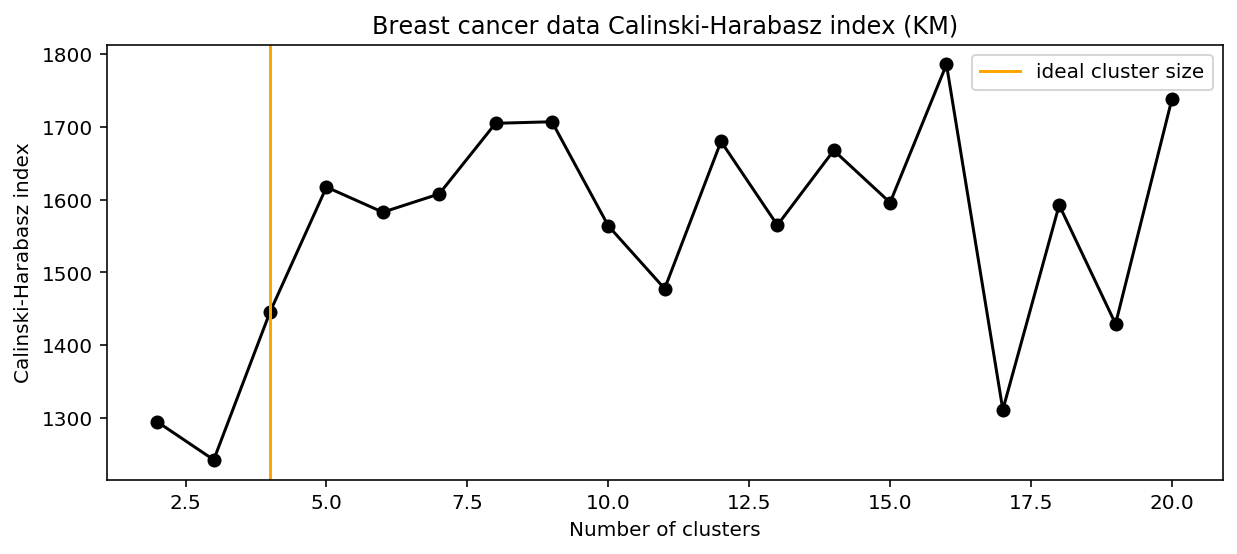

In [546]:
# plot CHI
plt.figure(figsize=(round((max_clusters-1)/2),4))
plt.plot(range(2, max_clusters), r['CHI'], marker='o', c='black')
plt.axvline(cluster_size, 0, 1, label='ideal cluster size', c="orange")
plt.legend(loc="best")
plt.xlabel('Number of clusters')
plt.ylabel('Calinski-Harabasz index')
plt.title('Breast cancer data Calinski-Harabasz index (KM)')
plt.show()

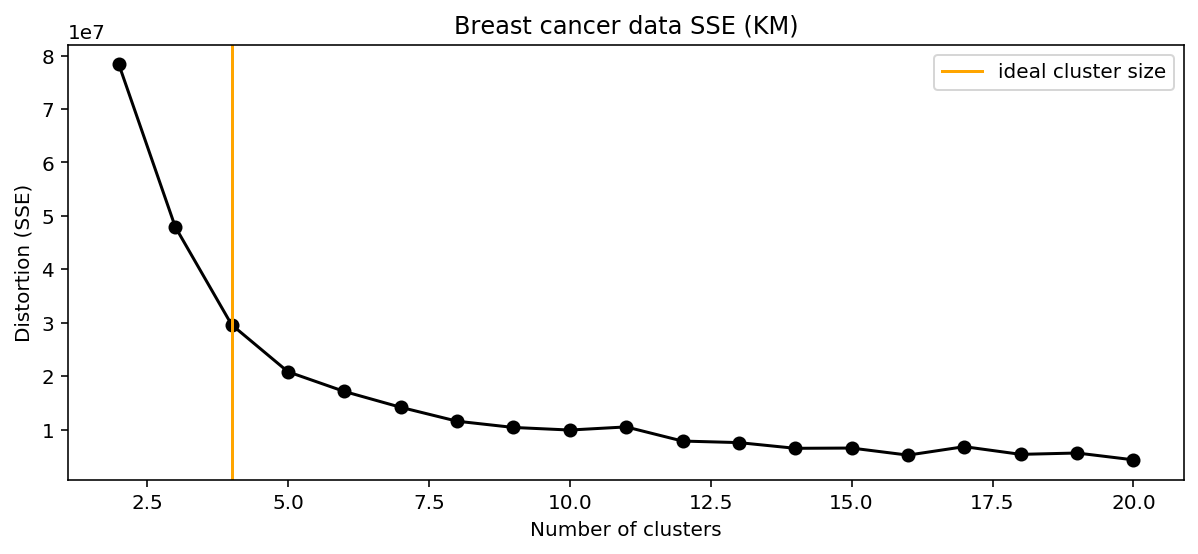

In [545]:
# plot SSE
plt.figure(figsize=(round((max_clusters-1)/2),4))
plt.plot(range(2, max_clusters), r['SSE'], marker='o', c='black')
plt.axvline(cluster_size, 0, 1, label='ideal cluster size', c="orange")
plt.legend(loc="best")
plt.xlabel('Number of clusters')
plt.ylabel('Distortion (SSE)')
plt.title('Breast cancer data SSE (KM)')
plt.show()

In [559]:
r, cluster_size = evalKmeans(adults_X, adults_y, max_clusters)
adults_cluster_size_km = cluster_size

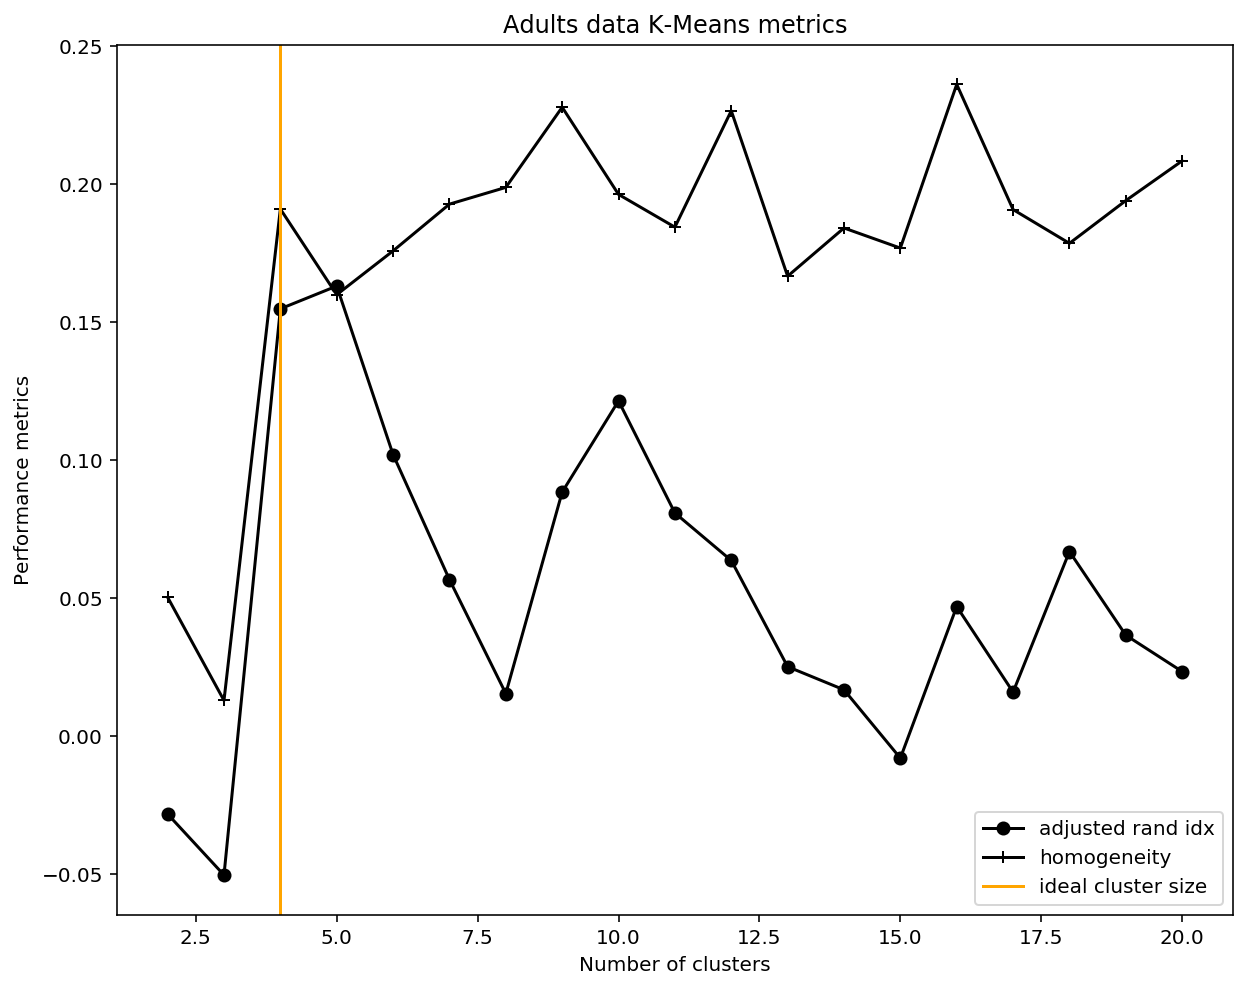

In [560]:
# plot
plt.figure(figsize=(round((max_clusters-1)/2),8))
plt.plot(range(2, max_clusters), r['ARI'], marker='o', c='black', label='adjusted rand idx')
plt.plot(range(2, max_clusters), r['homogeneity'], marker='+', c='black', label='homogeneity')
#plt.plot(range(2, max_clusters), r['DBI'], marker='v', c='black', label='DBI')
#plt.plot(range(2, max_clusters), r['completeness'], marker='v', c='black', label='completeness')
#plt.plot(range(2, max_clusters), r['v-measure'], marker='^', c='black', label='v-measure')
#plt.plot(range(2, max_clusters), r['FMI'], marker='D', c='black', label='Fowlkes-Mallows idx')
#plt.plot(range(2, max_clusters), r['DBI'], marker='x', c='black', label='Davies-Bouldin idx')
plt.axvline(cluster_size, 0, 1, label='ideal cluster size', c="orange")
plt.legend(loc="best")
plt.xlabel('Number of clusters')
plt.ylabel('Performance metrics')
plt.title('Adults data K-Means metrics')
plt.show()

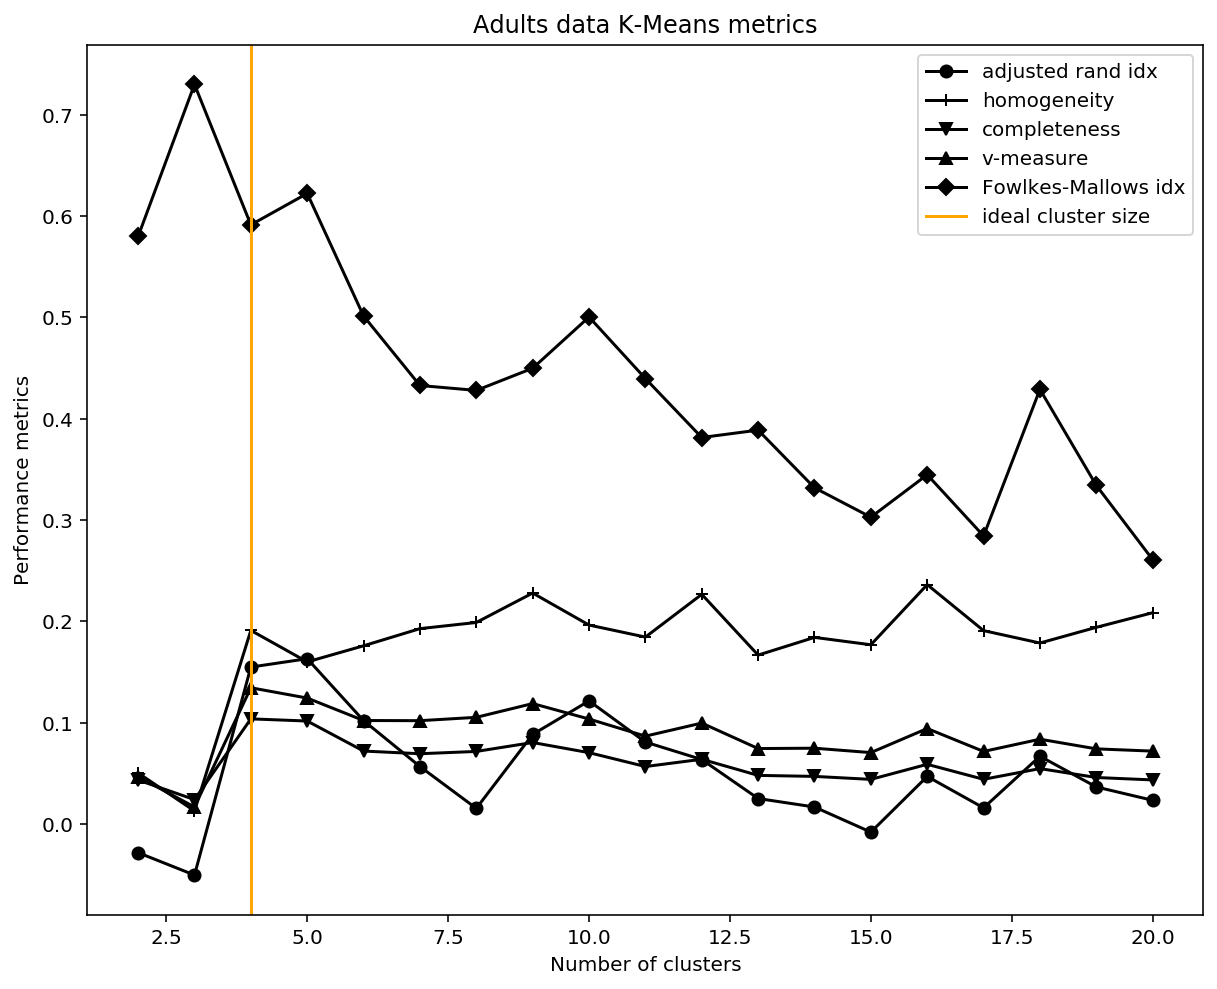

In [561]:
# plot
plt.figure(figsize=(round((max_clusters-1)/2),8))
plt.plot(range(2, max_clusters), r['ARI'], marker='o', c='black', label='adjusted rand idx')
plt.plot(range(2, max_clusters), r['homogeneity'], marker='+', c='black', label='homogeneity')
plt.plot(range(2, max_clusters), r['completeness'], marker='v', c='black', label='completeness')
plt.plot(range(2, max_clusters), r['v-measure'], marker='^', c='black', label='v-measure')
plt.plot(range(2, max_clusters), r['FMI'], marker='D', c='black', label='Fowlkes-Mallows idx')
#plt.plot(range(2, max_clusters), r['DBI'], marker='x', c='black', label='Davies-Bouldin idx')
plt.axvline(cluster_size, 0, 1, label='ideal cluster size', c="orange")
plt.legend(loc="best")
plt.xlabel('Number of clusters')
plt.ylabel('Performance metrics')
plt.title('Adults data K-Means metrics')
plt.show()

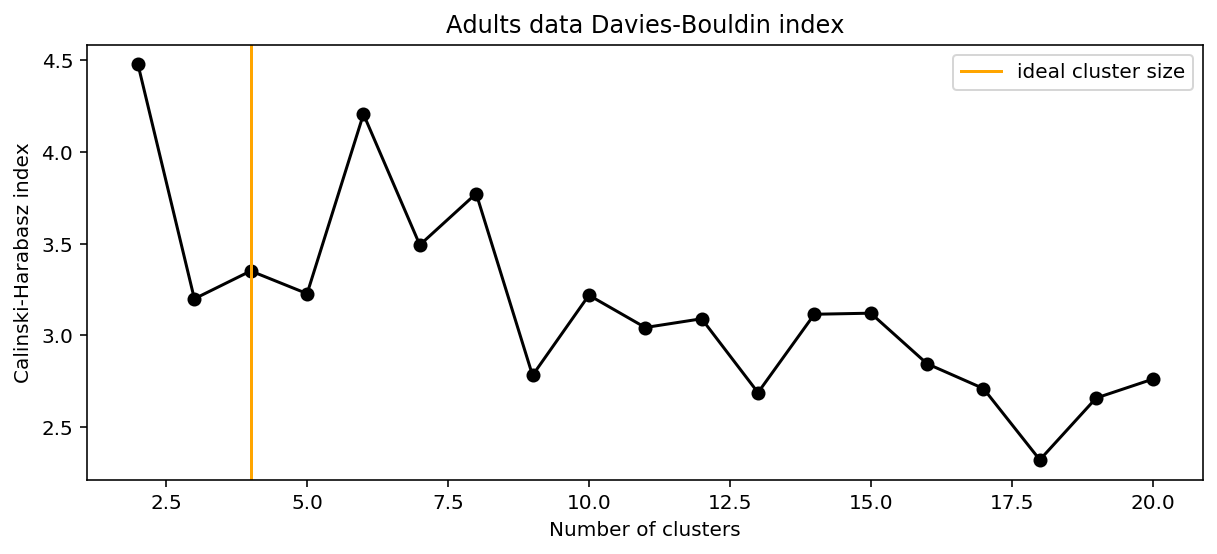

In [562]:
# plot DBI
plt.figure(figsize=(round((max_clusters-1)/2),4))
plt.plot(range(2, max_clusters), r['DBI'], marker='o', c='black')
plt.axvline(cluster_size, 0, 1, label='ideal cluster size', c="orange")
plt.legend(loc="best")
plt.xlabel('Number of clusters')
plt.ylabel('Davies-Bouldin index')
plt.title('Adults data Davies-Bouldin index')
plt.show()

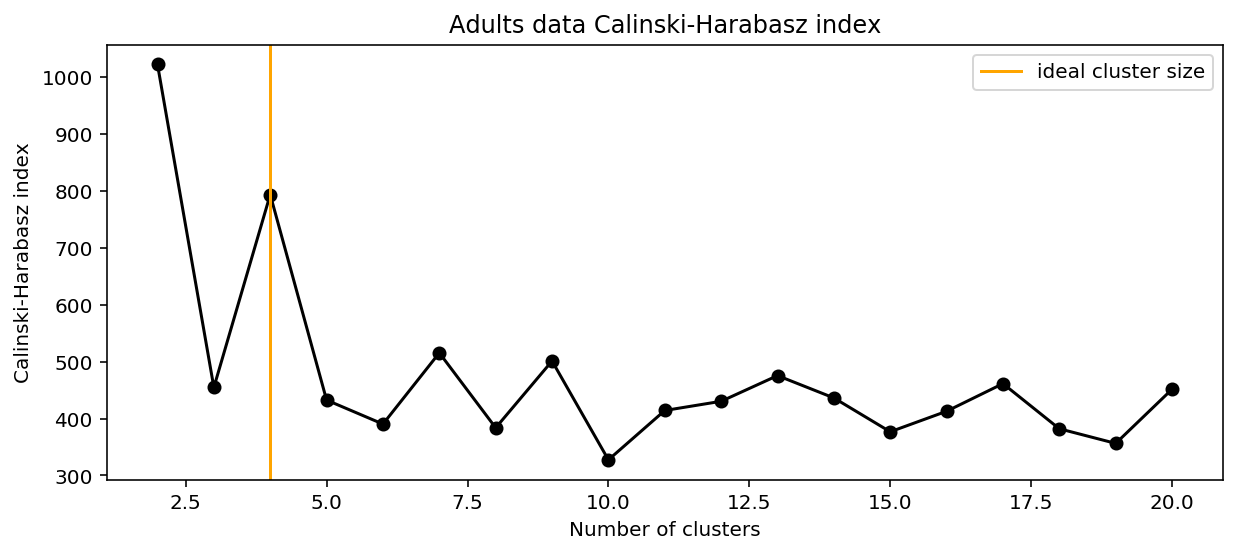

In [563]:
# plot CHI
plt.figure(figsize=(round((max_clusters-1)/2),4))
plt.plot(range(2, max_clusters), r['CHI'], marker='o', c='black')
plt.axvline(cluster_size, 0, 1, label='ideal cluster size', c="orange")
plt.legend(loc="best")
plt.xlabel('Number of clusters')
plt.ylabel('Calinski-Harabasz index')
plt.title('Adults data Calinski-Harabasz index')
plt.show()

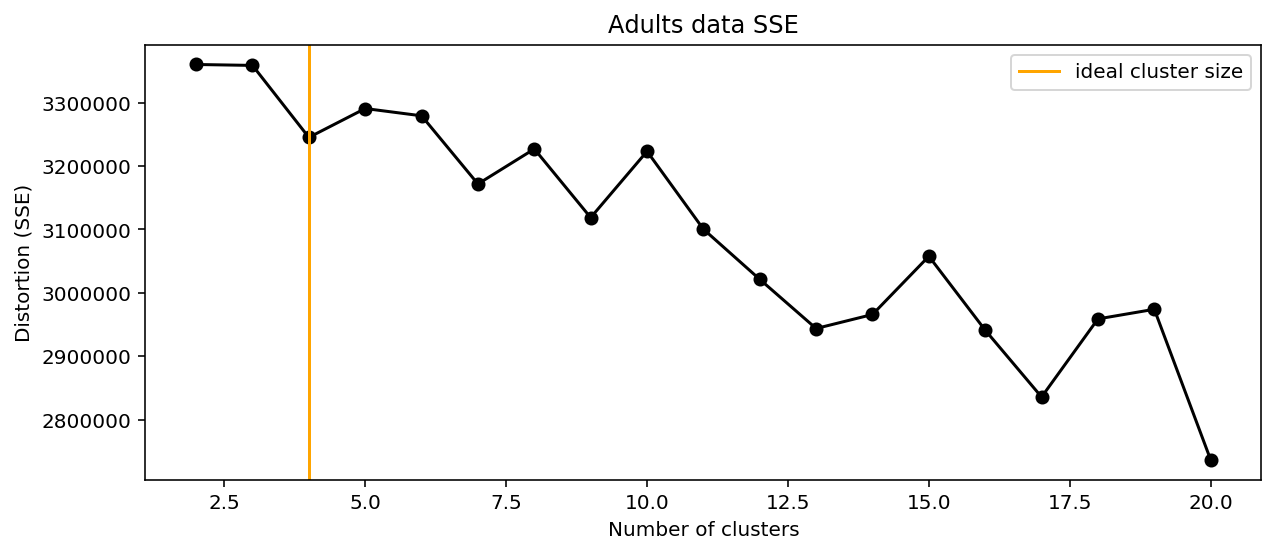

In [564]:
# plot SSE
plt.figure(figsize=(round((max_clusters-1)/2),4))
plt.plot(range(2, max_clusters), r['SSE'], marker='o', c='black')
plt.axvline(cluster_size, 0, 1, label='ideal cluster size', c="orange")
plt.legend(loc="best")
plt.xlabel('Number of clusters')
plt.ylabel('Distortion (SSE)')
plt.title('Adults data SSE')
plt.show()

In [565]:
def evalGM(X, y, max_clusters):
    results = {}
    #results['SSE'] = []
    results['ARI'] = [] #adjusted Rand index
    results['AMI'] = []
    results['homogeneity'] = []
    results['completeness'] = []
    results['v-measure'] = []
    results['FMI'] = []
    results['DBI'] = []
    results['CHI'] = []
    for i in range(2,max_clusters):
        gm = GaussianMixture(n_components = i, max_iter = 300).fit(X)
        labels = gm.predict(X)
        #results['SSE'].append(km.inertia_)
        results['ARI'].append(metrics.adjusted_rand_score(y, labels))
        results['AMI'].append(metrics.adjusted_mutual_info_score(y, labels))
        results['homogeneity'].append(metrics.homogeneity_score(y, labels))
        results['completeness'].append(metrics.completeness_score(y, labels))
        results['v-measure'].append(metrics.v_measure_score(y, labels))
        results['FMI'].append(metrics.fowlkes_mallows_score(y, labels))
        results['DBI'].append(metrics.davies_bouldin_score(X, labels))
        results['CHI'].append(metrics.calinski_harabasz_score(X, labels))
        
    #Find the ideal cluster size based on maximizing homogeneity and the ARI
    a, h = np.array(results['ARI']), np.array(results['homogeneity'])
    difference, average = np.absolute(a-h), np.mean([a, h], axis=0)

    m = 0
    for i in np.argsort(difference):
        if average[i] > m:
            m = average[i]
            idx = i
            
    return results, idx+2

In [580]:
r, cluster_size = evalGM(cancer_X, cancer_y, max_clusters)
cancer_cluster_size_em = cluster_size

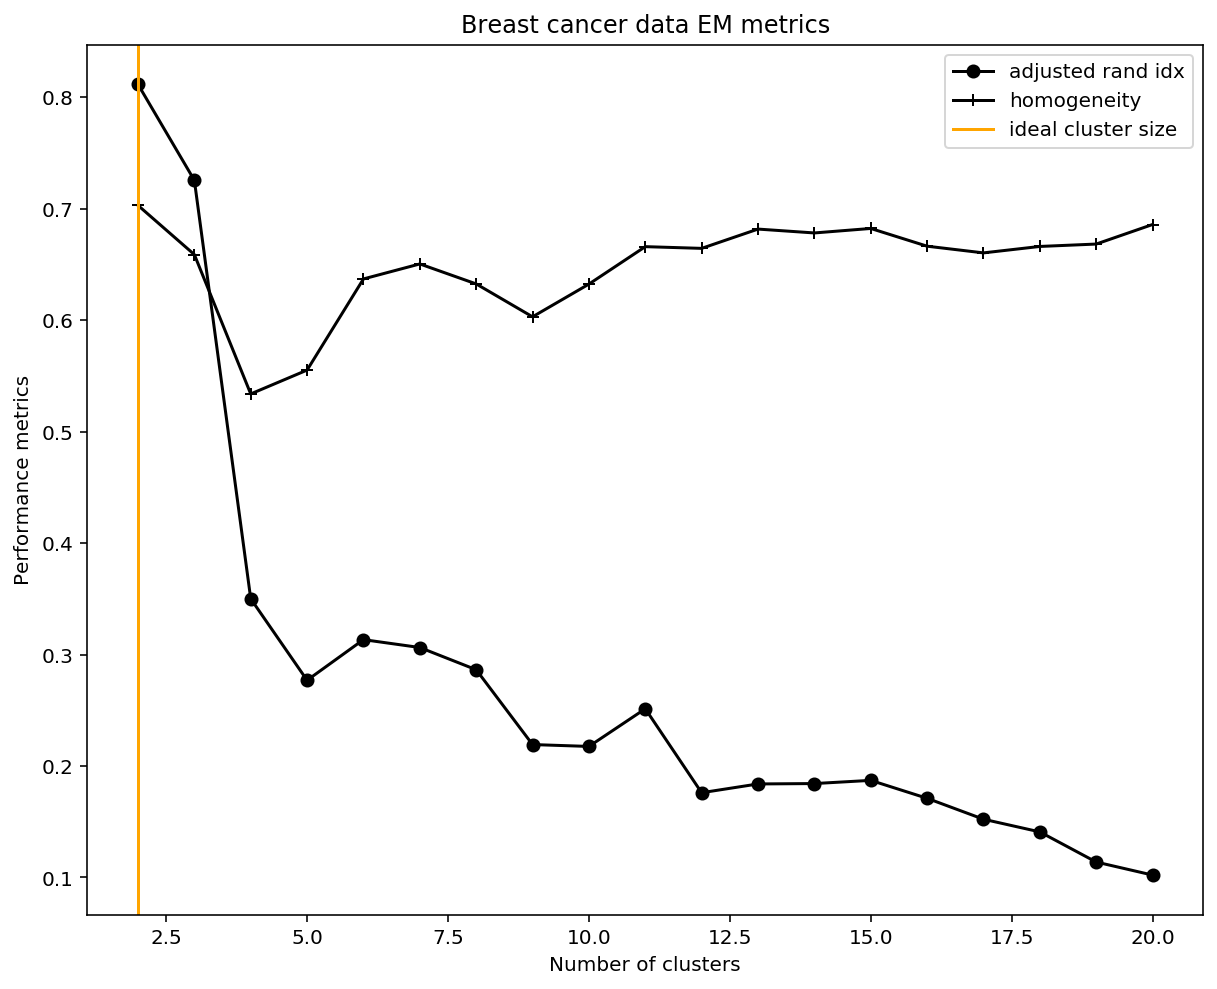

In [581]:
# plot
plt.figure(figsize=(round((max_clusters-1)/2),8))
plt.plot(range(2, max_clusters), r['ARI'], marker='o', c='black', label='adjusted rand idx')
plt.plot(range(2, max_clusters), r['homogeneity'], marker='+', c='black', label='homogeneity')
#plt.plot(range(2, max_clusters), r['completeness'], marker='v', c='black', label='completeness')
#plt.plot(range(2, max_clusters), r['v-measure'], marker='^', c='black', label='v-measure')
#plt.plot(range(2, max_clusters), r['FMI'], marker='D', c='black', label='Fowlkes-Mallows idx')
#plt.plot(range(2, max_clusters), r['DBI'], marker='x', c='black', label='Davies-Bouldin idx')
plt.axvline(cluster_size, 0, 1, label='ideal cluster size', c="orange")
plt.legend(loc="best")
plt.legend(loc="best")
plt.xlabel('Number of clusters')
plt.ylabel('Performance metrics')
plt.title('Breast cancer data EM metrics')
plt.show()

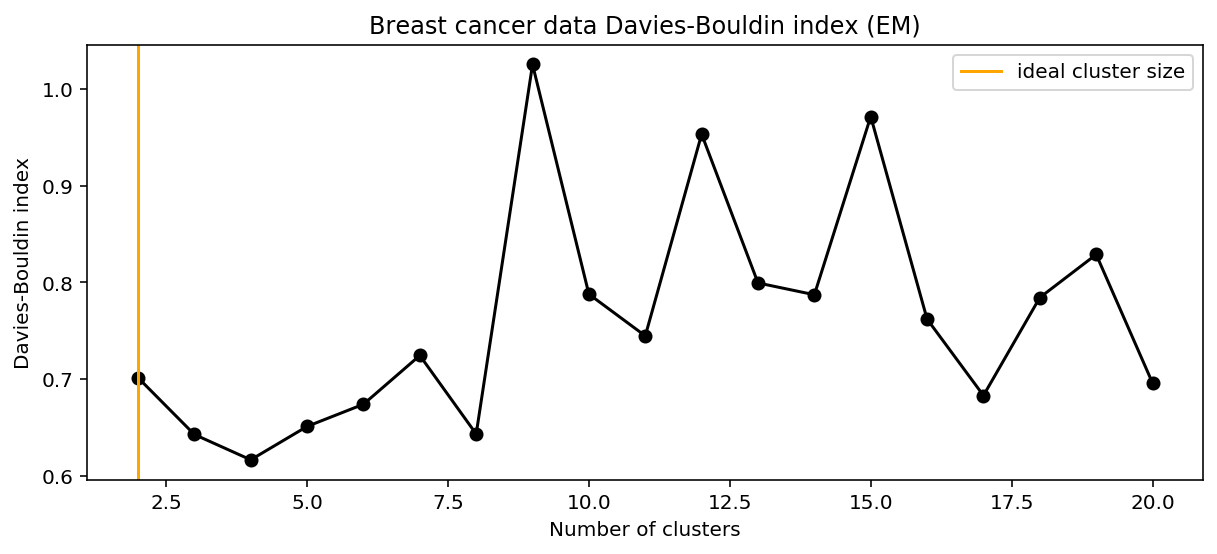

In [582]:
# plot DBI
plt.figure(figsize=(round((max_clusters-1)/2),4))
plt.plot(range(2, max_clusters), r['DBI'], marker='o', c='black')
plt.axvline(cluster_size, 0, 1, label='ideal cluster size', c="orange")
plt.legend(loc="best")
plt.xlabel('Number of clusters')
plt.ylabel('Davies-Bouldin index')
plt.title('Breast cancer data Davies-Bouldin index (EM)')
plt.show()

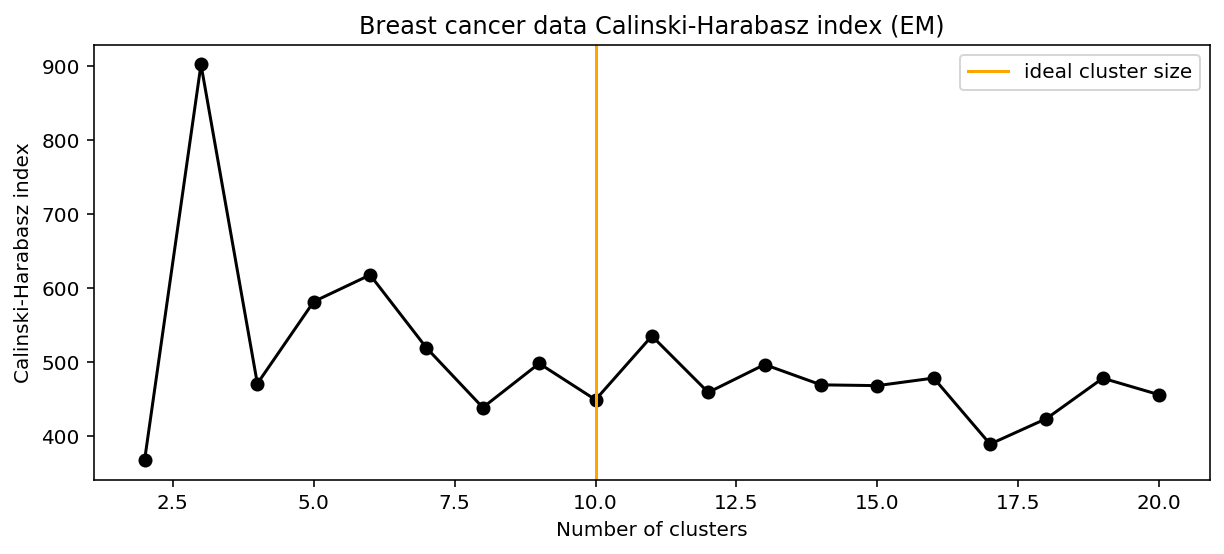

In [584]:
# plot CHI
plt.figure(figsize=(round((max_clusters-1)/2),4))
plt.plot(range(2, max_clusters), r['CHI'], marker='o', c='black')
plt.axvline(cluster_size, 0, 1, label='ideal cluster size', c="orange")
plt.legend(loc="best")
plt.xlabel('Number of clusters')
plt.ylabel('Calinski-Harabasz index')
plt.title('Breast cancer data Calinski-Harabasz index (EM)')
plt.show()

In [583]:
r, cluster_size = evalGM(adults_X, adults_y, max_clusters)
adults_cluster_size_em = cluster_size

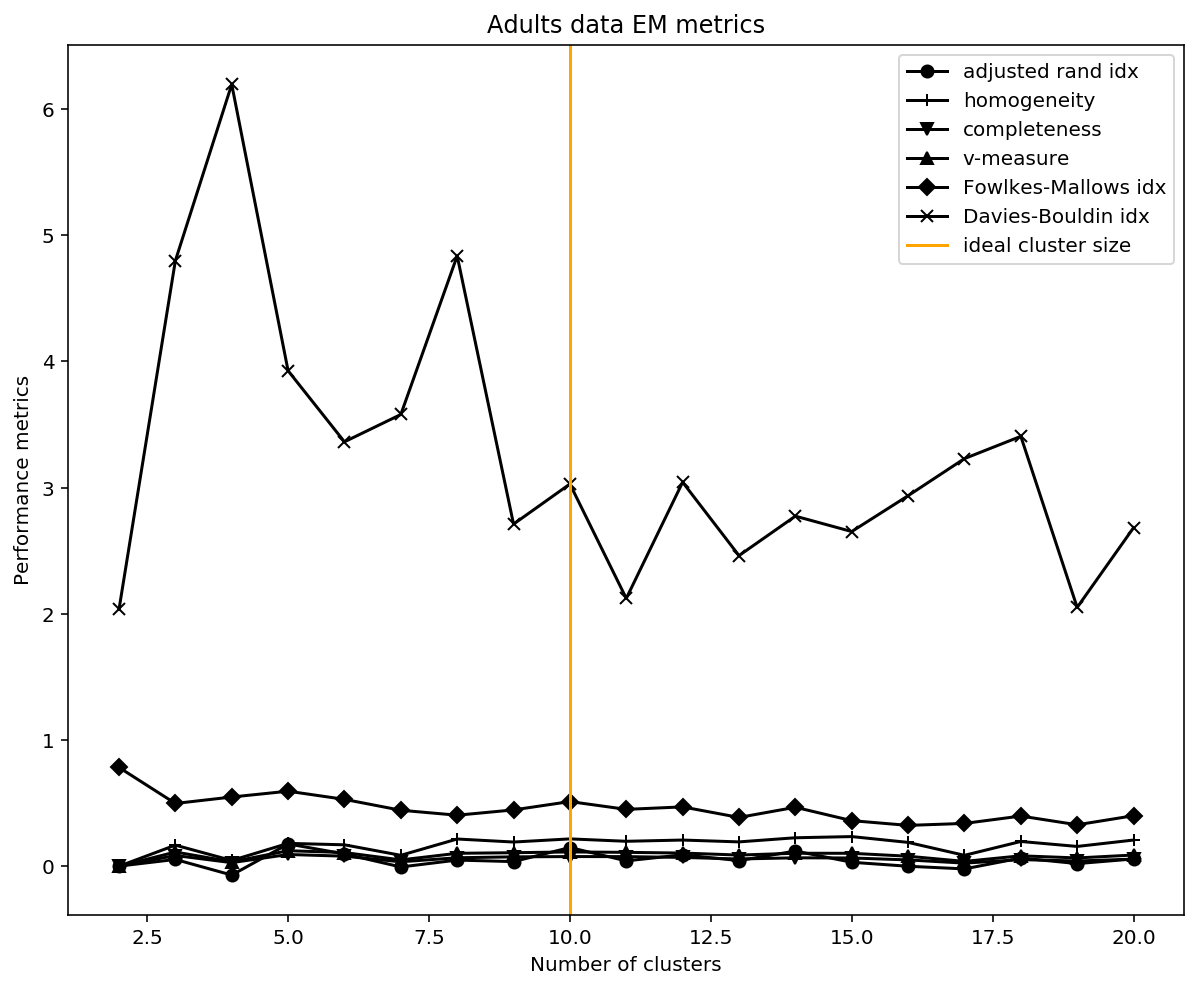

In [589]:
# plot
plt.figure(figsize=(round((max_clusters-1)/2),8))
plt.plot(range(2, max_clusters), r['ARI'], marker='o', c='black', label='adjusted rand idx')
plt.plot(range(2, max_clusters), r['homogeneity'], marker='+', c='black', label='homogeneity')
plt.plot(range(2, max_clusters), r['completeness'], marker='v', c='black', label='completeness')
plt.plot(range(2, max_clusters), r['v-measure'], marker='^', c='black', label='v-measure')
plt.plot(range(2, max_clusters), r['FMI'], marker='D', c='black', label='Fowlkes-Mallows idx')
plt.plot(range(2, max_clusters), r['DBI'], marker='x', c='black', label='Davies-Bouldin idx')
plt.axvline(cluster_size, 0, 1, label='ideal cluster size', c="orange")
plt.legend(loc="best")
plt.xlabel('Number of clusters')
plt.ylabel('Performance metrics')
plt.title('Adults data EM metrics')
plt.show()

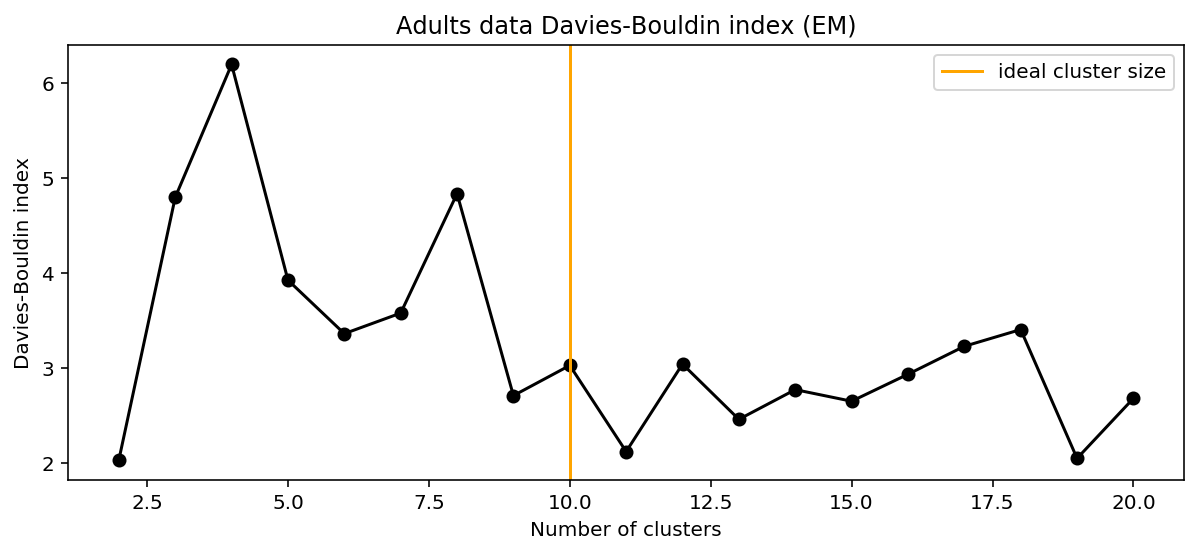

In [586]:
# plot DBI
plt.figure(figsize=(round((max_clusters-1)/2),4))
plt.plot(range(2, max_clusters), r['DBI'], marker='o', c='black')
plt.axvline(cluster_size, 0, 1, label='ideal cluster size', c="orange")
plt.legend(loc="best")
plt.xlabel('Number of clusters')
plt.ylabel('Davies-Bouldin index')
plt.title('Adults data Davies-Bouldin index (EM)')
plt.show()

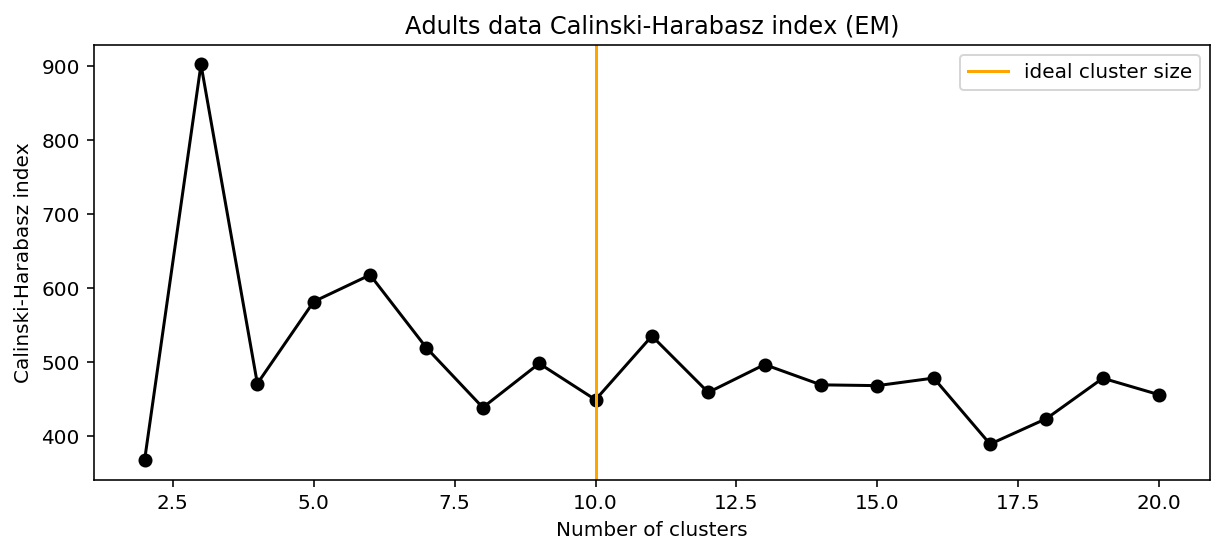

In [587]:
# plot CHI
plt.figure(figsize=(round((max_clusters-1)/2),4))
plt.plot(range(2, max_clusters), r['CHI'], marker='o', c='black')
plt.axvline(cluster_size, 0, 1, label='ideal cluster size', c="orange")
plt.legend(loc="best")
plt.xlabel('Number of clusters')
plt.ylabel('Calinski-Harabasz index')
plt.title('Adults data Calinski-Harabasz index (EM)')
plt.show()

In [449]:
def evalReductions(X, y, max_clusters, runs):
    results = {'n_components': [],
               'pca': {'km': {'c_size': [], 'metrics': []}, 'em': {'c_size': [], 'metrics': []}},
               'ica': {'km': {'c_size': [], 'metrics': []}, 'em': {'c_size': [], 'metrics': []}},
               'rca': {'km': {'c_size': [], 'metrics': []}, 'em': {'c_size': [], 'metrics': []}},
               'lda': {'km': {'c_size': [], 'metrics': []}, 'em': {'c_size': [], 'metrics': []}}}
    for i in range(X.shape[1],1,-round(X.shape[1]/runs)):
        results['n_components'].append(i)
        pca = PCA(n_components = i).fit_transform(X)
        ica = FastICA(n_components = i).fit_transform(X)
        rca = SparseRandomProjection(n_components = i).fit_transform(X)
        lda = LatentDirichletAllocation(n_components = i).fit_transform(X)
        #try KMeans and EM
        r, c = evalKmeans(pca, y, max_clusters)
        results['pca']['km']['c_size'].append(c)
        results['pca']['km']['metrics'].append(r)
        r, c = evalKmeans(ica, y, max_clusters)
        results['ica']['km']['c_size'].append(c)
        results['ica']['km']['metrics'].append(r)
        r, c = evalKmeans(rca, y, max_clusters)
        results['rca']['km']['c_size'].append(c)
        results['rca']['km']['metrics'].append(r)
        r, c = evalKmeans(lda, y, max_clusters)
        results['lda']['km']['c_size'].append(c)
        results['lda']['km']['metrics'].append(r)
        
        r, c = evalGM(pca, y, max_clusters)
        results['pca']['em']['c_size'].append(c)
        results['pca']['em']['metrics'].append(r)
        r, c = evalGM(ica, y, max_clusters)
        results['ica']['em']['c_size'].append(c)
        results['ica']['em']['metrics'].append(r)
        r, c = evalGM(rca, y, max_clusters)
        results['rca']['em']['c_size'].append(c)
        results['rca']['em']['metrics'].append(r)
        r, c = evalGM(lda, y, max_clusters)
        results['lda']['em']['c_size'].append(c)
        results['lda']['em']['metrics'].append(r)
        
    return results

In [591]:
runs = 9
X = cancer_X
for i in range(X.shape[1],1,-round(X.shape[1]/runs)):
    print(i, end=' ')

30 27 24 21 18 15 12 9 6 3 

In [458]:
runs = 6
data_cancer = evalReductions(cancer_X, cancer_y, max_clusters, runs)
data = data_cancer

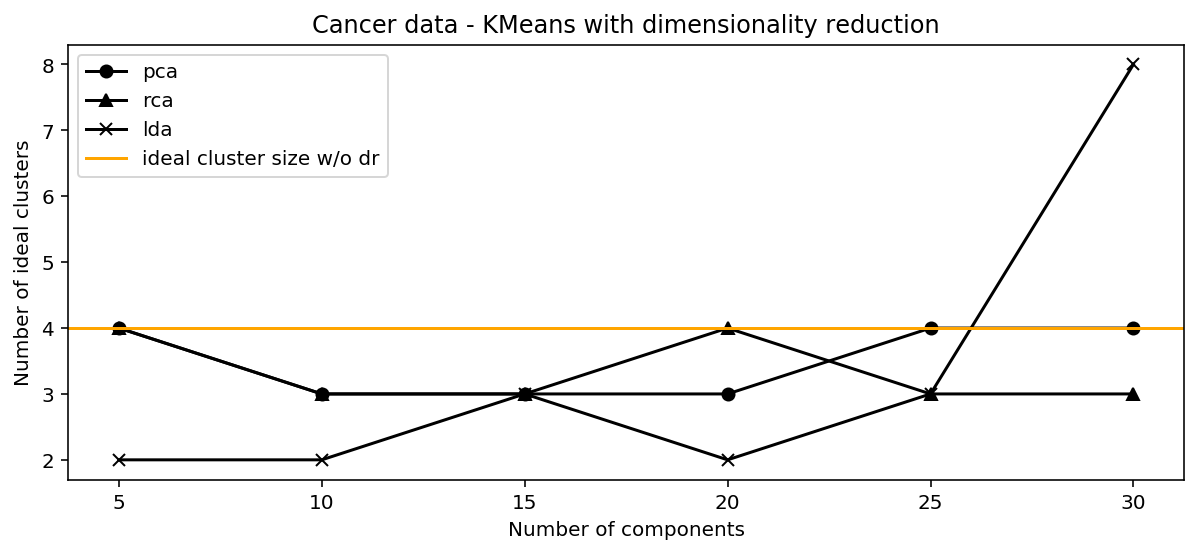

In [595]:
data = data_cancer
# plot Kmeans with dimension reductionality
plt.figure(figsize=(round((max_clusters-1)/2),4))
plt.plot(data['n_components'], data['pca']['km']['c_size'], marker='o', c='black', label='pca')
#plt.plot(data['n_components'], data['ica']['km']['c_size'], marker='+', c='black', label='ica')
plt.plot(data['n_components'], data['rca']['km']['c_size'], marker='^', c='black', label='rca')
plt.plot(data['n_components'], data['lda']['km']['c_size'], marker='x', c='black', label='lda')
plt.axhline(cancer_cluster_size_km, 0, 1, label='ideal cluster size w/o dr', c="orange")
plt.legend(loc="best")
plt.xlabel('Number of components')
plt.ylabel('Number of ideal clusters')
plt.title('Cancer data - KMeans with dimensionality reduction')
plt.show()

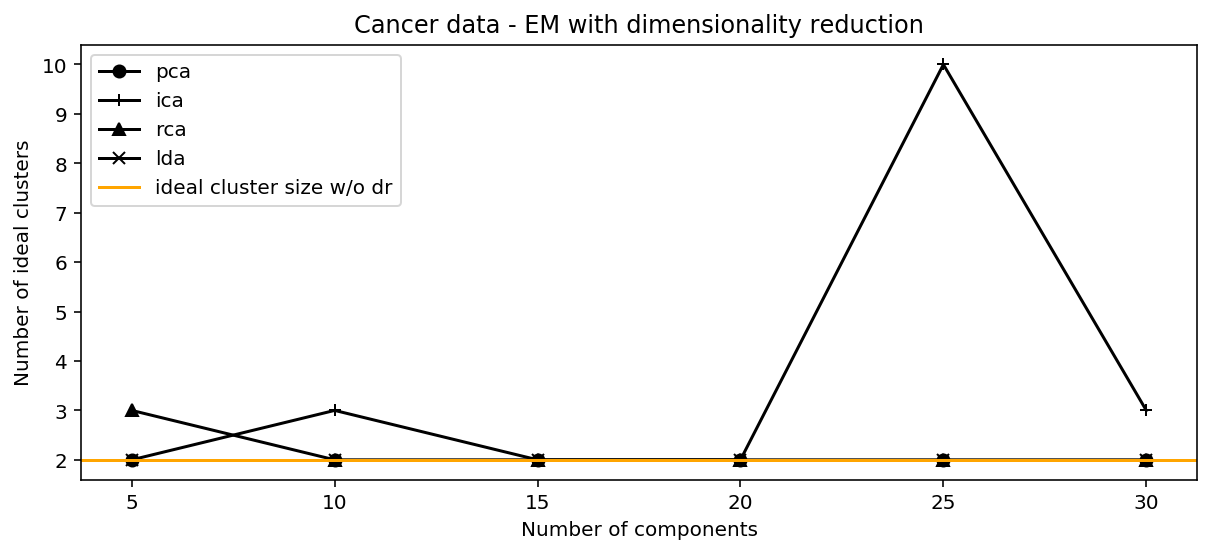

In [603]:
# plot EM with dimension reductionality
data = data_cancer
plt.figure(figsize=(round((max_clusters-1)/2),4))
plt.plot(data['n_components'], data['pca']['em']['c_size'], marker='o', c='black', label='pca')
plt.plot(data['n_components'], data['ica']['em']['c_size'], marker='+', c='black', label='ica')
plt.plot(data['n_components'], data['rca']['em']['c_size'], marker='^', c='black', label='rca')
plt.plot(data['n_components'], data['lda']['em']['c_size'], marker='x', c='black', label='lda')
plt.axhline(cancer_cluster_size_em, 0, 1, label='ideal cluster size w/o dr', c="orange")
plt.legend(loc="best")
plt.xlabel('Number of components')
plt.ylabel('Number of ideal clusters')
plt.title('Cancer data - EM with dimensionality reduction')
plt.show()

In [464]:
runs = 6
data_adults = evalReductions(cancer_X, cancer_y, max_clusters, runs)
data = data_adults

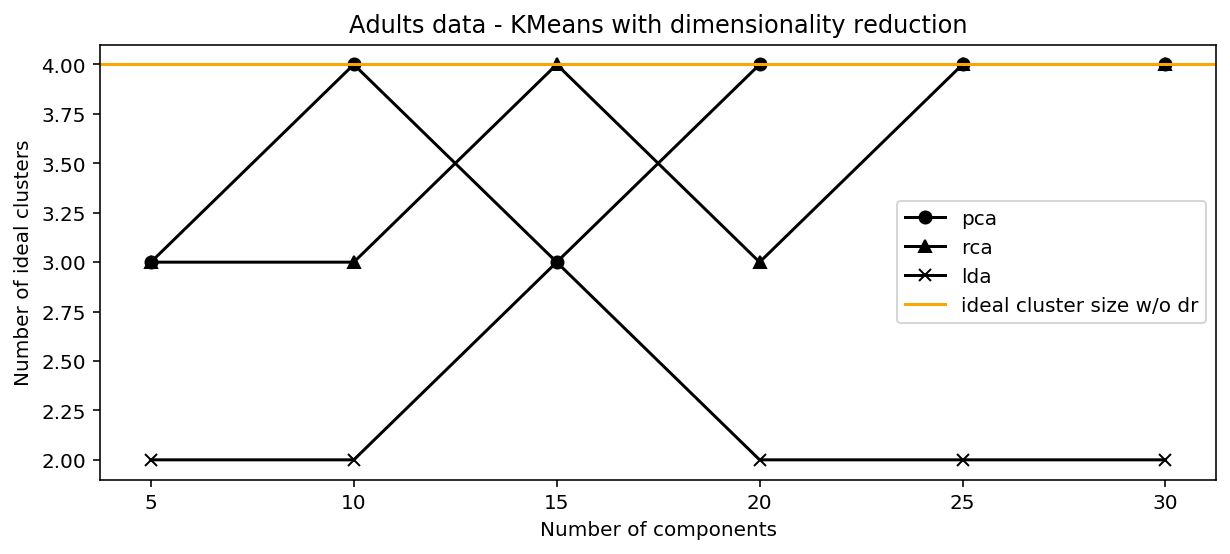

In [597]:
data = data_adults
# plot Kmeans with dimension reductionality
plt.figure(figsize=(round((max_clusters-1)/2),4))
plt.plot(data['n_components'], data['pca']['km']['c_size'], marker='o', c='black', label='pca')
plt.plot(data['n_components'], data['ica']['km']['c_size'], marker='+', c='black', label='ica')
plt.plot(data['n_components'], data['rca']['km']['c_size'], marker='^', c='black', label='rca')
plt.plot(data['n_components'], data['lda']['km']['c_size'], marker='x', c='black', label='lda')
plt.axhline(adults_cluster_size_km, 0, 1, label='ideal cluster size w/o dr', c="orange")
plt.legend(loc="best")
plt.xlabel('Number of components')
plt.ylabel('Number of ideal clusters')
plt.title('Adults data - KMeans with dimensionality reduction')
plt.show()

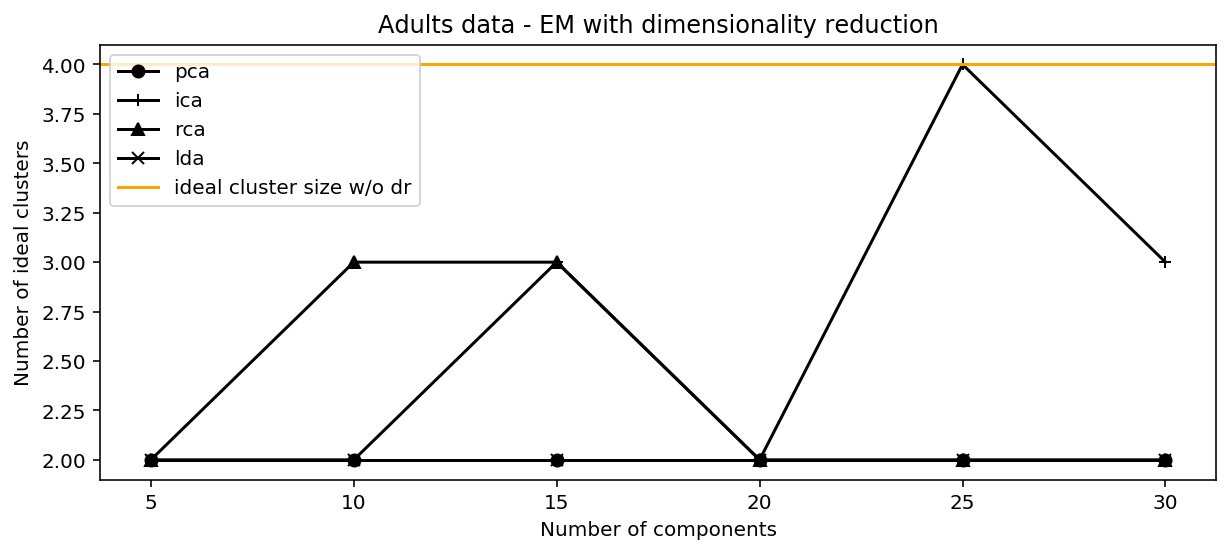

In [602]:
# plot EM with dimension reductionality
data = data_adults
plt.figure(figsize=(round((max_clusters-1)/2),4))
plt.plot(data['n_components'], data['pca']['em']['c_size'], marker='o', c='black', label='pca')
plt.plot(data['n_components'], data['ica']['em']['c_size'], marker='+', c='black', label='ica')
plt.plot(data['n_components'], data['rca']['em']['c_size'], marker='^', c='black', label='rca')
plt.plot(data['n_components'], data['lda']['em']['c_size'], marker='x', c='black', label='lda')
plt.axhline(4, 0, 1, label='ideal cluster size w/o dr', c="orange")
plt.legend(loc="best")
plt.xlabel('Number of components')
plt.ylabel('Number of ideal clusters')
plt.title('Adults data - EM with dimensionality reduction')
plt.show()

## Find a target dimensionality

In [599]:
data = data_adults
data['lda']['em']['c_size']

[2, 2, 2, 2, 2, 2]

In [476]:
pca_data = PCA(n_components = 10).fit_transform(adults_X)

In [490]:
em_clusters = GaussianMixture(n_components = 2, max_iter = 300).fit_predict(pca_data)

In [495]:
max(em_clusters)

1

In [492]:
adults_X.shape

(32561, 106)

## Retrain the neural network

In [467]:
def _gridSearchCV(estimator, param_grid, X, y, test_size=0.2):
    grid_search = GridSearchCV(
        estimator=estimator(),
        param_grid=param_grid,
        cv=StratifiedShuffleSplit(n_splits=10, test_size=test_size),
        scoring=metrics.make_scorer(metrics.roc_auc_score),
        n_jobs=-1
    )
    grid_search.fit(X, y)
    return grid_search

def calc_learning_curve(estimator, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 10)):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    return train_sizes, train_scores, test_scores

def plot_learning_curve(title, train_sizes, train_scores, test_scores, ylim=None):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

#Save the metrics
def getPerfMetrics(gridSearchCVmodel, X, y, model_name, pos_name, neg_name):
    gs = gridSearchCVmodel
    
    gs_res = pd.DataFrame(gs.cv_results_)

    y_pred = gs.predict(X)

    accuracy = metrics.accuracy_score(y, y_pred)
    AUROC = gs.score(X, y)
    confusion_matrix= metrics.confusion_matrix(y, y_pred)
    prfs = metrics.precision_recall_fscore_support(y, y_pred)

    confusion_matrix_frac = confusion_matrix / prfs[3].sum()
    confusion_matrix_frac = pd.DataFrame(confusion_matrix_frac, 
             columns=['pred '+neg_name, 'pred '+pos_name],
            index=['actual '+neg_name, 'actual '+pos_name])

    params = pd.DataFrame(
        gs.best_params_,
        index=[model_name+" best parameters"]
    )
    gen_results = pd.DataFrame(
        {'Accuracy': accuracy,
         'AUROC-score': AUROC
        },
        index=[model_name]
    )
    class_results = pd.DataFrame(
         {'Precision': prfs[0],
         'Recall': prfs[1],
         'F-score': prfs[2],
         'Support': prfs[3]
         },
        index=[pos_name,neg_name]
    )

    return gs.cv_results_, params, gen_results, class_results, confusion_matrix_frac

In [521]:
def trainNN(X, y):
    model_name = 'Neural Network'
    pos_class = '> $50k'
    neg_class = '<= $50k'
    
    param_grid = [{
        'hidden_layer_sizes': [(n,) for n in list(range(1,20,1))],
        'solver': ['lbfgs','sgd','adam'],
        'activation': ['relu','logistic'],
        'learning_rate': ['constant','invscaling']
    }]
    gs_mlp_a = _gridSearchCV(
        MLPClassifier, 
        param_grid,
        X, 
        y)

    #Calculate the learning curve
    cv = StratifiedShuffleSplit(n_splits=5, test_size=0.1)
    estimator = MLPClassifier(**gs_mlp_a.best_params_)
    train_sizes, train_scores, test_scores = calc_learning_curve(
        estimator, X, y, cv=cv)
    
    cv_res, params, gen_res, class_res, conf_mat = getPerfMetrics(gs_mlp_a, X, y, 
                                                                  model_name, 
                                                                  pos_class, 
                                                                  neg_class)
    return train_sizes, train_scores, test_scores, cv_res, params, gen_res, class_res, conf_mat

In [522]:
start_time = time.time()
em_train_sizes, em_train_scores, em_test_scores = trainNN(em_clusters, adults_y)
em_train_time = time.time() - start_time
print("--- %s seconds with DR and clustering ---" % (em_train_time))

ValueError: Expected 2D array, got 1D array instead:
array=[0 1 1 ... 0 1 1].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [523]:
start_time = time.time()
pca_train_sizes, pca_train_scores, pca_test_scores, pca_cv_res, pca_params, pca_gen_res, pca_class_res, pca_conf_mat = trainNN(pca_data, adults_y)
pca_train_time = time.time() - start_time
print("--- %s seconds with DR ---" % (pca_train_time))

--- 773.8321952819824 seconds with DR ---


In [524]:
start_time = time.time()
a_train_sizes, a_train_scores, a_test_scores, a_cv_res, a_params, a_gen_res, a_class_res, a_conf_mat = trainNN(adults_X, adults_y)
a_train_time = time.time() - start_time
print("--- %s seconds for full training ---" % (a_train_time))

--- 1683.6150929927826 seconds for full training ---


In [525]:
pca_conf_mat

,pred <= $50k,pred > $50k
actual <= $50k,0.687510,0.071681
actual > $50k,0.098861,0.141949


In [526]:
a_conf_mat

,pred <= $50k,pred > $50k
actual <= $50k,0.682319,0.076871
actual > $50k,0.088480,0.152329


In [528]:
pca_params

,activation,hidden_layer_sizes,learning_rate,solver
Neural Network best parameters,logistic,1,constant,sgd


In [529]:
a_params

,activation,hidden_layer_sizes,learning_rate,solver
Neural Network best parameters,logistic,1,constant,sgd


In [530]:
pca_gen_res

,Accuracy,AUROC-score
Neural Network,0.829459,0.747524


In [531]:
a_gen_res

,Accuracy,AUROC-score
Neural Network,0.834649,0.765659


In [532]:
pca_class_res

,Precision,Recall,F-score,Support
> $50k,0.874282,0.905583,0.889657,24720
<= $50k,0.664462,0.589466,0.624721,7841


In [533]:
a_class_res

,Precision,Recall,F-score,Support
> $50k,0.885210,0.898746,0.891927,24720
<= $50k,0.664612,0.632572,0.648197,7841


<module 'matplotlib.pyplot' from '/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

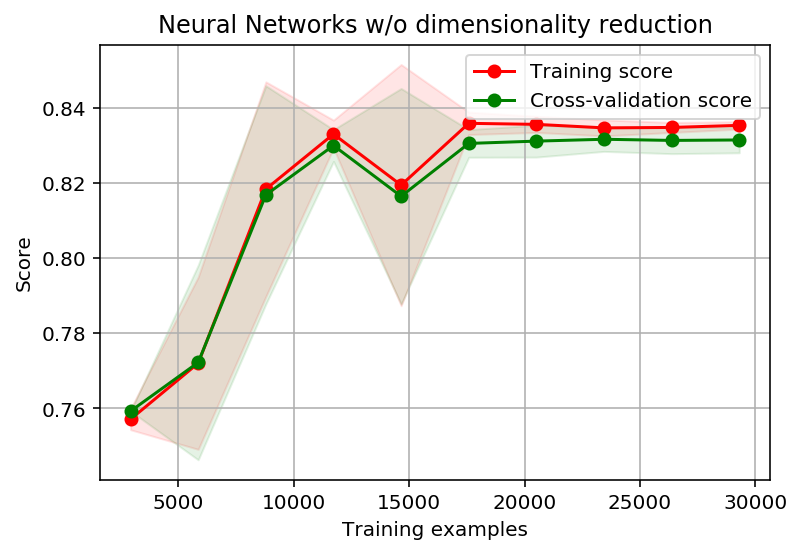

In [535]:
#Print the learning curve
title = "Neural Networks w/o dimensionality reduction"
plot_learning_curve(title, a_train_sizes, a_train_scores, a_test_scores)

<module 'matplotlib.pyplot' from '/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

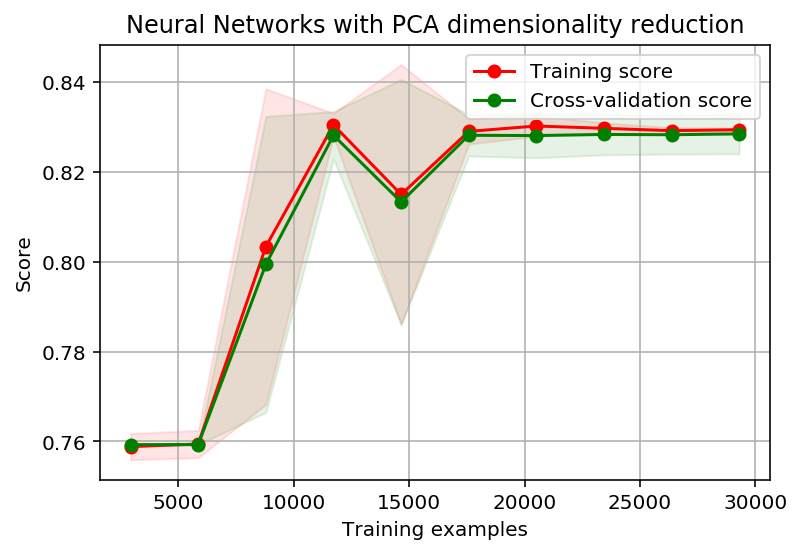

In [536]:
#Print the learning curve
title = "Neural Networks with PCA dimensionality reduction"
plot_learning_curve(title, pca_train_sizes, pca_train_scores, pca_test_scores)

In [70]:
#adjusted Rand index 
# measures the similarity of the two assignments, ignoring permutations and with chance normalization
# Perfect labeling is scored 1.0:
metrics.adjusted_rand_score(y, km.labels_)

0.49142453622455523

In [71]:
#SSE
km.inertia_

77983941.27944538

In [72]:
#Adjusted Mutual Information (AMI) 
#Random (uniform) label assignments have a AMI score close to 0.0 for any value of n_clusters and n_samples (which is not the case for raw Mutual Information or the V-measure for instance).
metrics.adjusted_mutual_info_score(y, km.labels_)

0.42151741598216214

In [73]:
#homogeneity: each cluster contains only members of a single class. (higher is better)
#completeness: all members of a given class are assigned to the same cluster. (higher is better)
#V-measure: symmetric, can be used to evaluate the agreement of two independent assignments on the same dataset.
metrics.homogeneity_completeness_v_measure(y, km.labels_)

(0.42229071246999117, 0.5168089972809706, 0.46479332792160793)

In [74]:
#Fowlkes-Mallows index
# No assumption is made on the cluster structure: 
# can be used to compare clustering algorithms such as k-means which assumes isotropic blob shapes with results of spectral clustering algorithms which can find cluster with “folded” shapes.
metrics.fowlkes_mallows_score(y, km.labels_)

0.7915171728708068

In [83]:
#Davies-Bouldin index
#a lower Davies-Bouldin index relates to a model with better separation between the clusters
metrics.davies_bouldin_score(X, km.labels_)

0.5044035685410975

In [77]:
#Calinski-Harabasz index
#a higher Calinski-Harabasz score relates to a model with better defined clusters
#dispersion
metrics.calinski_harabasz_score(X, km.labels_)

1300.2082268895422